# Trabajo de Visión Artificial

## Dataset
[Dataset de señales de tráfico - kaggle](https://www.kaggle.com/datasets/msalman97/dataset-for-traffic-sign-master-app/data)

### Info obtenida del datacard
Este conjunto de datos consiste en más de 60 señales de tráfico. El conjunto fue creado utilizando señales del **German Traffic Sign Recognition Benchmark Dataset**, señales recolectadas localmente, señales de distintos conjuntos de datos y imágenes de señales obtenidas de Internet. Las imágenes fueron aumentadas utilizando un script en Python.

Las imágenes aumentadas se procesaron de la siguiente manera:

**Redimensionamiento:** 32x32, 64x64, 128x128, 256x256

**Reducción de brillo:** -60%

**Aumento de brillo:** +60%

**Desenfoque aplicado a:** imágenes de 128x128, 256x256 y originales

**Niebla añadida a:** imágenes de 128x128, 256x256 y originales

**Alteración de color:** brillo, contraste y color con valores de 1.8

Después de la ampliación, las imágenes se renombran así:
`[00000_00001_00012]`

* `00000` corresponde a la clase

* `00001` corresponde al lote de imágenes de la clase 0 (contiene 29 imágenes); después de 29 imágenes pasará a `[00002]`

* `00012` indica el número de imágenes en una clase

Este conjunto de datos se utiliza para entrenar un modelo **CNN personalizado** para la detección de imágenes e integrar el modelo entrenado en una aplicación móvil desarrollada en **Flutter**.

Dentro de este conjunto de datos también hay una carpeta **Testing**, que se usa para probar y validar el modelo después del entrenamiento. Las imágenes de esta carpeta son nuevas, tomadas y recortadas de Internet.

Si estás siguiendo mi proyecto en GitHub **Traffic-Sign-Master-App** y deseas usar este conjunto de datos en el código original, descárgalo y colócalo dentro de la carpeta **Backend**. Todas las clases de señales están listadas en el archivo **traffic_sign_classes.py**.

Para el reconocimiento en tiempo real de señales de tráfico usando **Yolov5**, he creado un conjunto de datos que contiene imágenes etiquetadas de señales para detección.
**Conjunto de datos Yolo:** [https://www.kaggle.com/datasets/msalman97/signs-dataset-yolov5format](https://www.kaggle.com/datasets/msalman97/signs-dataset-yolov5format)

Si encuentras útil este conjunto de datos, por favor dame crédito visitando mi perfil de GitHub: [https://github.com/salman-97](https://github.com/salman-97). Sígueme para actualizaciones y explora mi repositorio completo para más proyectos y recursos. Tu apoyo significa mucho.


In [1]:
import os
from PIL import Image
from collections import Counter
import pandas as pd 
import os


# Añadiendo basepath > Si se trabaja en colab hay que agregar un directorio
dir_base = "/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset" # Cambiar por la ruta local (Estoy usando WSL y un disco compartido)

def resumen_dataset(dir_base, muestra=5):
    print(">>> Exploración del dataset <<<")
    print("Directorio base:", dir_base)
    print()

    if not os.path.exists(dir_base):
        print("La ruta no existe, revisa el path.")
        return

    dim_cont = Counter()
    res_clase = {}
    directorios = ['Train', 'Test', 'Testing']

    for directorio in directorios:
        dir_path = os.path.join(dir_base, directorio)
        if os.path.isdir(dir_path):
            print(f"\nExplorando directorio: {directorio}")
            cont_imgs = 0
            for root, _, archivos in os.walk(dir_path):
                img_archivos = [f for f in archivos if f.lower().endswith(('.jpg','.jpeg','.png'))]
                cont_imgs += len(img_archivos)
            res_clase[directorio] = cont_imgs
        else:
            print(f"\nDirectorio '{directorio}' no encontrado en la ruta base.")


    # Resumen por directorio
    print("\n>>> Número de imágenes por directorio encontrado <<<")
    for cls, cont in res_clase.items():
        print(f"{cls}: {cont} imágenes")

# Ejecutar resumen 
resumen_dataset(dir_base)

>>> Exploración del dataset <<<
Directorio base: /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset


Explorando directorio: Train

Explorando directorio: Test

Explorando directorio: Testing

>>> Número de imágenes por directorio encontrado <<<
Train: 78532 imágenes
Test: 3625 imágenes
Testing: 139 imágenes


Ahora, veamos solo los elementos del directorio "Train" que tiene clases bien definidas en subdirectorios

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Función para contar imágenes por clase en el directorio Train
def contar_imagenes_por_clase(dir_base):
    dir_train = os.path.join(dir_base, "Train")
    if not os.path.exists(dir_train):
        print(f"El directorio {dir_train} no existe.")
        return None
    
    # Obtener lista de subdirectorios (clases)
    clases = [d for d in os.listdir(dir_train) if os.path.isdir(os.path.join(dir_train, d))]
    
    # Contar imágenes por clase
    conteo = {}
    for clase in clases:
        dir_clase = os.path.join(dir_train, clase)
        imagenes = [f for f in os.listdir(dir_clase) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        conteo[clase] = len(imagenes)
    
    # Crear DataFrame
    df_conteo = pd.DataFrame(list(conteo.items()), columns=['clase', 'instancias'])
    
    print(f"Número total de clases: {len(df_conteo)}")
    return df_conteo

# Ejecutar la función
df_clases = contar_imagenes_por_clase(dir_base)
df_clases

Número total de clases: 63


,clase,instancias
0,0,935
1,1,2858
2,10,2300
3,11,1697
4,12,2390
...,...,...
58,61,919
59,62,1160
60,7,2281
61,8,2135


### Formación del dataset para el trabajo

In [10]:
# Función para seleccionar imágenes aleatorias de cada clase
def seleccionar_imagenes_aleatorias(dir_train, num_imagenes_por_clase=5, semilla=42):
    # Establecer semilla para reproducibilidad
    random.seed(semilla)
    
    # Verificar que el directorio existe
    if not os.path.exists(dir_train):
        print(f"El directorio {dir_train} no existe.")
        return {}
    
    # Obtener lista de subdirectorios (clases)
    clases_dirs = [d for d in os.listdir(dir_train) if os.path.isdir(os.path.join(dir_train, d))]
    
    # Diccionario para almacenar las imágenes seleccionadas
    imagenes_seleccionadas = {}
    
    # Seleccionar imágenes aleatorias de cada clase
    for clase_dir in clases_dirs:
        path_clase = os.path.join(dir_train, clase_dir)
        
        if os.path.isdir(path_clase):
            archivos_img = [f for f in os.listdir(path_clase) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            if len(archivos_img) < num_imagenes_por_clase:
                # Si hay menos imágenes que las solicitadas, se toman todas
                seleccion = archivos_img
            else:
                # Selecciona aleatoriamente el número de imágenes especificado
                seleccion = random.sample(archivos_img, num_imagenes_por_clase)
            
            # Almacena las rutas completas de las imágenes seleccionadas
            imagenes_seleccionadas[clase_dir] = [os.path.join(path_clase, img) for img in seleccion]
            
    return imagenes_seleccionadas

# Uso de la función
# Seleccionamos 209 imágenes por cada clase del directorio Train -> Se escoge 209 por ser el mínimo de instancias
dir_entrenamiento = os.path.join(dir_base, "Train")
muestra_imagenes = seleccionar_imagenes_aleatorias(dir_entrenamiento, num_imagenes_por_clase=5, semilla=2212)

# Imprimir una muestra del resultado para verificar
print(f"Se seleccionaron imágenes de {len(muestra_imagenes)} clases.")
print("Ejemplo para la clase '0':")
for ruta_img in muestra_imagenes.get('0', [])[:2]:  # Mostrar solo las primeras 2 rutas
    print(ruta_img)

print("\nEjemplo para la clase '10':")
for ruta_img in muestra_imagenes.get('10', [])[:2]:  # Mostrar solo las primeras 2 rutas
    print(ruta_img)

Se seleccionaron imágenes de 63 clases.
Ejemplo para la clase '0':
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/0/00000_00017_00016.png
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/0/00000_00006_00023.png

Ejemplo para la clase '10':
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/10/00010_00037_00020.png
/mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/10/00010_00057_00020.png


## Pipeline para Segmentación por color con HSV

In [16]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Crear directorio HSV si no existe
hsv_dir = 'HSV'
if not os.path.exists(hsv_dir):
    os.makedirs(hsv_dir)
    print(f"Directorio '{hsv_dir}' creado exitosamente")
else:
    print(f"El directorio '{hsv_dir}' ya existe")

Directorio 'HSV' creado exitosamente


In [17]:
def segmentar_hsv(imagen_path, output_dir):
    """
    Segmenta una imagen usando el espacio de color HSV.
    
    Args:
        imagen_path (str): Ruta a la imagen a procesar
        output_dir (str): Directorio donde guardar la imagen segmentada
    
    Returns:
        tuple: (máscara_hsv, imagen_segmentada)
    """
    # Leer la imagen
    imagen = cv2.imread(imagen_path)
    if imagen is None:
        print(f"No se pudo leer la imagen: {imagen_path}")
        return None, None

    # Convertir BGR a HSV
    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    
    # Definir rangos de color para señales de tráfico (rojo, azul y amarillo)
    # Rojo (considerando que el rojo en HSV está en los extremos del rango H)
    rojo_bajo1 = np.array([0, 100, 100])
    rojo_alto1 = np.array([10, 255, 255])
    rojo_bajo2 = np.array([160, 100, 100])
    rojo_alto2 = np.array([180, 255, 255])
    
    # Azul
    azul_bajo = np.array([100, 100, 100])
    azul_alto = np.array([130, 255, 255])
    
    # Amarillo
    amarillo_bajo = np.array([20, 100, 100])
    amarillo_alto = np.array([30, 255, 255])
    
    # Crear máscaras para cada color
    mascara_rojo1 = cv2.inRange(hsv, rojo_bajo1, rojo_alto1)
    mascara_rojo2 = cv2.inRange(hsv, rojo_bajo2, rojo_alto2)
    mascara_azul = cv2.inRange(hsv, azul_bajo, azul_alto)
    mascara_amarillo = cv2.inRange(hsv, amarillo_bajo, amarillo_alto)
    
    # Combinar todas las máscaras
    mascara_hsv = cv2.bitwise_or(mascara_rojo1, mascara_rojo2)
    mascara_hsv = cv2.bitwise_or(mascara_hsv, mascara_azul)
    mascara_hsv = cv2.bitwise_or(mascara_hsv, mascara_amarillo)
    
    # Aplicar operaciones morfológicas para mejorar la segmentación
    kernel = np.ones((5,5), np.uint8)
    mascara_hsv = cv2.morphologyEx(mascara_hsv, cv2.MORPH_OPEN, kernel)
    mascara_hsv = cv2.morphologyEx(mascara_hsv, cv2.MORPH_CLOSE, kernel)
    
    # Aplicar la máscara a la imagen original
    imagen_segmentada = cv2.bitwise_and(imagen, imagen, mask=mascara_hsv)
    
    # Guardar la imagen segmentada
    nombre_archivo = os.path.basename(imagen_path)
    ruta_salida = os.path.join(output_dir, f"hsv_{nombre_archivo}")
    cv2.imwrite(ruta_salida, imagen_segmentada)
    
    return mascara_hsv, imagen_segmentada

In [18]:
# Procesar todas las imágenes del diccionario muestra_imagenes
resultados_hsv = {}

# Crear subdirectorios para cada clase en el directorio HSV
for clase in muestra_imagenes.keys():
    clase_dir = os.path.join(hsv_dir, clase)
    if not os.path.exists(clase_dir):
        os.makedirs(clase_dir)

# Procesar cada imagen
for clase, rutas_imagenes in tqdm(muestra_imagenes.items(), desc="Procesando clases"):
    resultados_hsv[clase] = []
    
    # Crear directorio para la clase si no existe
    output_dir = os.path.join(hsv_dir, clase)
    
    for ruta_imagen in rutas_imagenes:
        try:
            mascara, imagen_segmentada = segmentar_hsv(ruta_imagen, output_dir)
            if mascara is not None:
                resultados_hsv[clase].append({
                    'ruta_original': ruta_imagen,
                    'ruta_segmentada': os.path.join(output_dir, f"hsv_{os.path.basename(ruta_imagen)}")
                })
        except Exception as e:
            print(f"Error procesando {ruta_imagen}: {str(e)}")

print("HSV Completo")

Procesando clases: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s]

HSV Completo


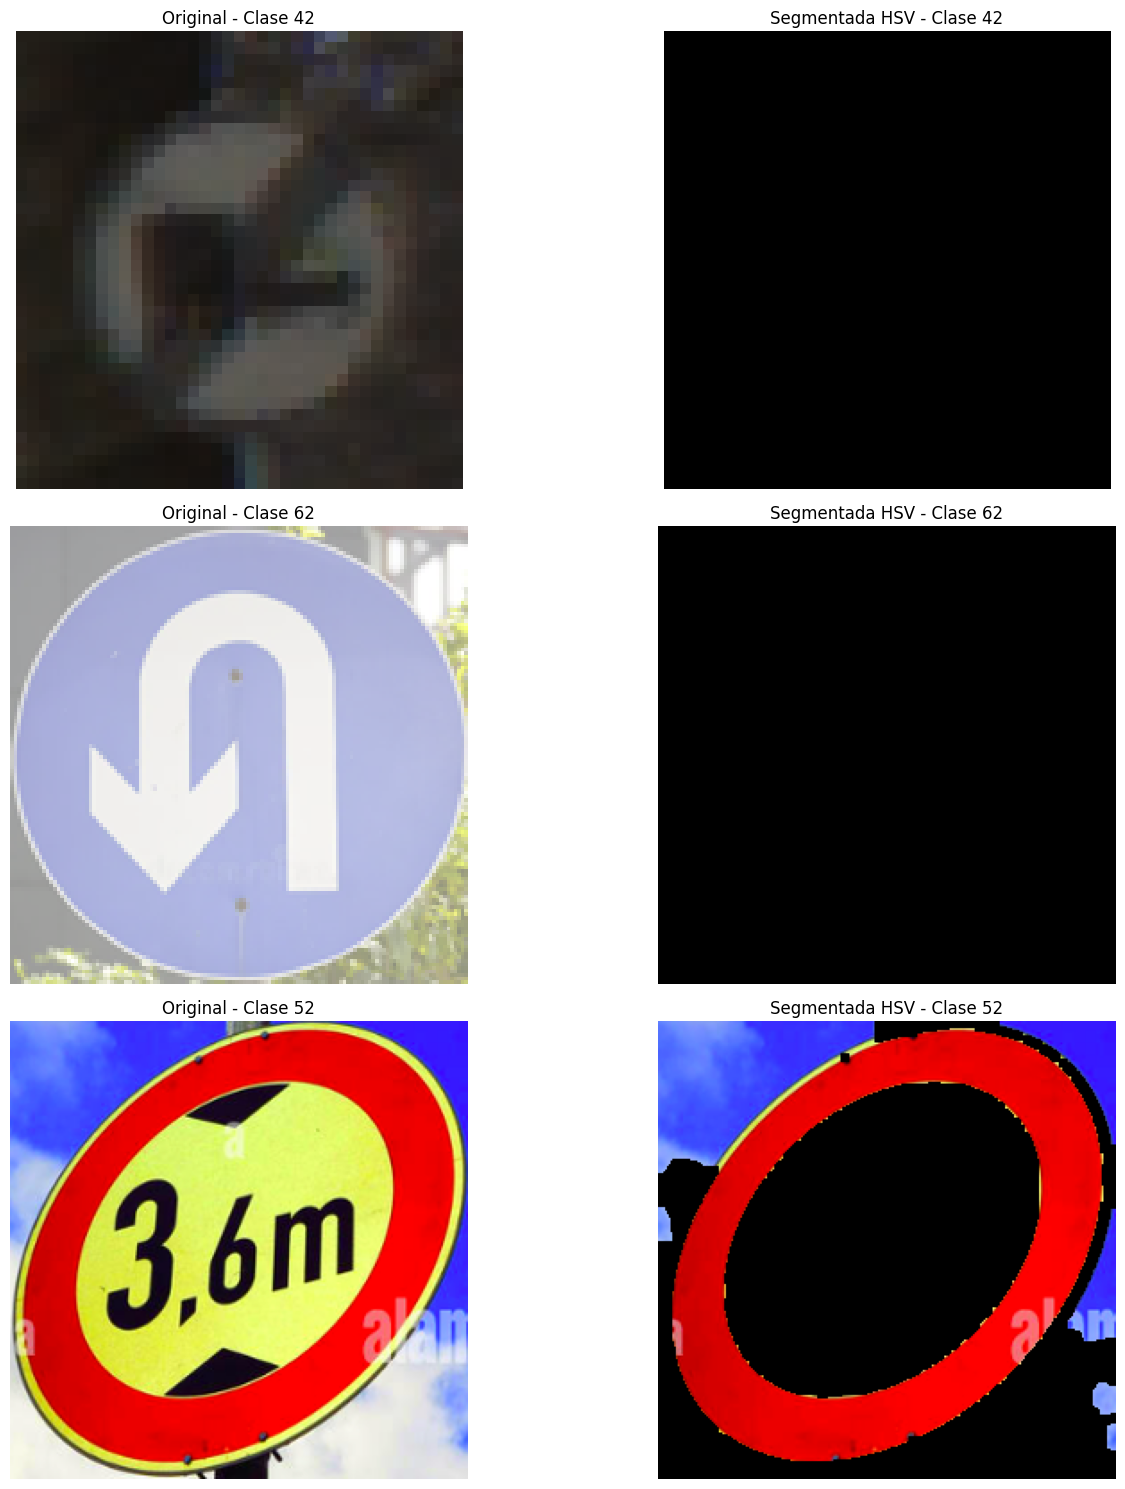

In [19]:
def visualizar_resultados_hsv(resultados_hsv, num_muestras=3):
    """
    Visualiza los resultados de la segmentación HSV mostrando la imagen original y la segmentada.
    
    Args:
        resultados_hsv (dict): Diccionario con los resultados de la segmentación
        num_muestras (int): Número de muestras aleatorias a visualizar
    """
    # Seleccionar clases aleatorias
    clases = list(resultados_hsv.keys())
    clases_muestra = np.random.choice(clases, min(num_muestras, len(clases)), replace=False)
    
    # Configurar el tamaño de la figura
    fig = plt.figure(figsize=(15, 5 * num_muestras))
    
    for i, clase in enumerate(clases_muestra):
        if not resultados_hsv[clase]:  # Si no hay resultados para esta clase
            continue
            
        # Seleccionar una imagen aleatoria de esta clase
        resultado = np.random.choice(resultados_hsv[clase])
        
        # Leer imágenes
        img_original = cv2.cvtColor(cv2.imread(resultado['ruta_original']), cv2.COLOR_BGR2RGB)
        img_segmentada = cv2.cvtColor(cv2.imread(resultado['ruta_segmentada']), cv2.COLOR_BGR2RGB)
        
        # Mostrar imágenes
        plt.subplot(num_muestras, 2, 2*i + 1)
        plt.imshow(img_original)
        plt.title(f"Original - Clase {clase}")
        plt.axis('off')
        
        plt.subplot(num_muestras, 2, 2*i + 2)
        plt.imshow(img_segmentada)
        plt.title(f"Segmentada HSV - Clase {clase}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizar algunos resultados aleatorios
visualizar_resultados_hsv(resultados_hsv, num_muestras=3)

## Detección de señales de tráfico con YOLO
Implementación de un pipeline para utilizar un modelo YOLO preentrenado para la detección de señales de tráfico.

In [11]:
# Instalación de dependencias necesarias para YOLO
#!pip install ultralytics opencv-python matplotlib torch torchvision tqdm

# Verificar la instalación
import sys
print(f"Python version: {sys.version}")
!uv pip list | grep -E "ultralytics|opencv-python|matplotlib|torch|tqdm" #Cambiar si no se usa uv como gestor de paquetes

Python version: 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
matplotlib                3.10.7
matplotlib-inline         0.1.7
opencv-python             4.12.0.88
torch                     2.8.0
torchvision               0.23.0
tqdm                      4.67.1
ultralytics               8.3.208
ultralytics-thop          2.0.17


In [12]:
# Revisando GPU
import torch
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Dispositivo CUDA: {torch.cuda.get_device_name(0)}")
    print(f"Número de dispositivos CUDA: {torch.cuda.device_count()}")
else:
    print("Solo CPU")

CUDA disponible: True
Dispositivo CUDA: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Número de dispositivos CUDA: 1


In [13]:
# Cargar el modelo YOLO preentrenado
from ultralytics import YOLO

# Usando YOLOv11n entrenado con señales de tráfico 
model = YOLO('traffic_sign_detector.pt') # https://github.com/bhaskrr/traffic-sign-detection-using-yolov11
print(f"Modelo YOLO cargado con {len(model.model.names)} clases")
print(model.model.names)

Modelo YOLO cargado con 15 clases
{0: 'Green Light', 1: 'Red Light', 2: 'Speed Limit 10', 3: 'Speed Limit 100', 4: 'Speed Limit 110', 5: 'Speed Limit 120', 6: 'Speed Limit 20', 7: 'Speed Limit 30', 8: 'Speed Limit 40', 9: 'Speed Limit 50', 10: 'Speed Limit 60', 11: 'Speed Limit 70', 12: 'Speed Limit 80', 13: 'Speed Limit 90', 14: 'Stop'}


In [14]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO
import cv2

def procesar_diccionario_imagenes(muestra_imagenes, modelo, conf_threshold=0.25):
    """
    Procesa las imágenes contenidas en un diccionario usando el modelo YOLO.
    
    Args:
        muestra_imagenes (dict): Diccionario donde las llaves son clases ('0' a '62') 
                              y los valores son rutas a imágenes
        modelo: Modelo YOLO cargado
        conf_threshold (float): Umbral de confianza para las detecciones (0-1)
        
    Returns:
        pd.DataFrame: DataFrame con los resultados de las predicciones
    """
    # Lista para almacenar los resultados
    resultados = []
    
    # Configurar dispositivo para usar GPU si está disponible
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Usando dispositivo: {device}")
    
    # Procesar cada clase en el diccionario
    for clase, rutas_imagenes in tqdm(muestra_imagenes.items(), desc="Procesando clases"):
        # Si rutas_imagenes es una sola ruta (string), convertirla a lista
        if isinstance(rutas_imagenes, str):
            rutas_imagenes = [rutas_imagenes]
        
        # Procesar cada imagen de la clase
        for ruta_imagen in rutas_imagenes:
            # Verificar que la imagen existe
            if not os.path.exists(ruta_imagen):
                print(f"Advertencia: La imagen {ruta_imagen} no existe. Saltando...")
                continue
                
            try:
                # Realizar la detección con el modelo YOLO
                results = modelo(ruta_imagen, conf=conf_threshold, device=device)
                result = results[0]  # Tomamos el primer resultado (una sola imagen)
                
                # Si no hay detecciones, añadir una fila con valores nulos para las detecciones
                if len(result.boxes) == 0:
                    resultados.append({
                        'clase_real': clase,
                        'ruta_imagen': ruta_imagen,
                        'clase_predicha': None,
                        'confianza': None,
                        'bbox': None
                    })
                else:
                    # Para cada detección en la imagen
                    for box in result.boxes:
                        cls_id = int(box.cls.item())
                        cls_name = result.names[cls_id]
                        conf = box.conf.item()
                        bbox = box.xyxy.tolist()[0]  # Convertir a lista [x1, y1, x2, y2]
                        
                        # Añadir resultado a la lista
                        resultados.append({
                            'clase_real': clase,
                            'ruta_imagen': ruta_imagen,
                            'clase_predicha': cls_name,
                            'confianza': conf,
                            'bbox': bbox
                        })
            except Exception as e:
                print(f"Error al procesar la imagen {ruta_imagen}: {str(e)}")
                # Añadir fila con error
                resultados.append({
                    'clase_real': clase,
                    'ruta_imagen': ruta_imagen,
                    'clase_predicha': 'ERROR',
                    'confianza': None,
                    'bbox': None,
                    'error': str(e)
                })
    
    # Crear DataFrame con los resultados
    df_resultados = pd.DataFrame(resultados)
    
    return df_resultados

def visualizar_resultados_muestra(df_resultados, num_muestras=3):
    """
    Visualiza una muestra de imágenes con sus predicciones.
    
    Args:
        df_resultados (pd.DataFrame): DataFrame con los resultados de las predicciones
        num_muestras (int): Número de imágenes a visualizar
    """
    # Filtrar solo filas con detecciones válidas
    df_con_detecciones = df_resultados[df_resultados['clase_predicha'].notna() & 
                                     (df_resultados['clase_predicha'] != 'ERROR')]
    
    # Si no hay detecciones válidas, mostrar mensaje
    if len(df_con_detecciones) == 0:
        print("No hay detecciones válidas para visualizar.")
        return
    
    # Seleccionar imágenes únicas para visualizar
    rutas_unicas = df_con_detecciones['ruta_imagen'].unique()
    num_muestras = min(num_muestras, len(rutas_unicas))
    rutas_muestra = np.random.choice(rutas_unicas, num_muestras, replace=False)
    
    # Configurar el tamaño de la figura
    plt.figure(figsize=(15, 5 * num_muestras))
    
    # Visualizar cada imagen seleccionada
    for i, ruta_imagen in enumerate(rutas_muestra):
        # Obtener todas las detecciones para esta imagen
        detecciones = df_con_detecciones[df_con_detecciones['ruta_imagen'] == ruta_imagen]
        clase_real = detecciones['clase_real'].iloc[0]
        
        # Cargar la imagen
        imagen = cv2.imread(ruta_imagen)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        
        # Dibujar las detecciones en la imagen
        for _, det in detecciones.iterrows():
            if det['bbox'] is not None:
                x1, y1, x2, y2 = map(int, det['bbox'])
                cv2.rectangle(imagen, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # Añadir etiqueta con clase y confianza
                etiqueta = f"{det['clase_predicha']}: {det['confianza']:.2f}"
                cv2.putText(imagen, etiqueta, (x1, y1 - 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Mostrar la imagen con las detecciones
        plt.subplot(num_muestras, 1, i + 1)
        plt.imshow(imagen)
        plt.title(f"Imagen: {os.path.basename(ruta_imagen)} | Clase real: {clase_real}")
        plt.axis('off')
        
        # Mostrar detalle de las detecciones
        info_detecciones = "\n".join([
            f"Detección {i+1}: {det['clase_predicha']}, Confianza: {det['confianza']:.2f}"
            for i, (_, det) in enumerate(detecciones.iterrows())
        ])
        plt.figtext(0.5, 0.01 + (i / num_muestras), info_detecciones, 
                   ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5})
    
    plt.tight_layout()
    plt.show()

'\n# Cargar el modelo YOLO\nmodel = YOLO(\'traffic_sign_detector.pt\')\n\n# Procesar las imágenes del diccionario\ndf_resultados = procesar_diccionario_imagenes(muestra_imagenes, model, conf_threshold=0.25)\n\n# Mostrar el DataFrame con los resultados\nprint("Resultados de la detección:")\ndisplay(df_resultados)\n\n# Estadísticas básicas\nprint("\nEstadísticas:")\nprint(f"Total de imágenes procesadas: {df_resultados[\'ruta_imagen\'].nunique()}")\nprint(f"Total de detecciones: {len(df_resultados[df_resultados[\'clase_predicha\'].notna()])}")\n\n# Mostrar distribución de clases predichas\nif \'clase_predicha\' in df_resultados.columns and df_resultados[\'clase_predicha\'].notna().any():\n    print("\nDistribución de clases predichas:")\n    display(df_resultados[\'clase_predicha\'].value_counts().head(10))\n\n# Visualizar algunos resultados\nvisualizar_resultados_muestra(df_resultados, num_muestras=3)\n'

### Caso de uso

Usando dispositivo: cuda


Procesando clases:   0%|          | 0/63 [00:00<?, ?it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/0/00000_00017_00016.png: 640x640 1 Speed Limit 20, 26.6ms
Speed: 3.7ms preprocess, 26.6ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/0/00000_00006_00023.png: 640x608 1 Speed Limit 20, 26.9ms
Speed: 4.7ms preprocess, 26.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/0/00000_00031_00002.png: 640x640 1 Speed Limit 20, 28.1ms
Speed: 3.4ms preprocess, 28.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/0/00000_00006_00026.png: 640x640 1 Speed Limit 20, 26.6ms
Speed: 3.5ms preprocess, 26.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/0/000

Procesando clases:   2%|▏         | 1/63 [00:01<01:24,  1.36s/it]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/1/00001_00048_00020.png: 640x640 1 Speed Limit 30, 25.9ms
Speed: 4.8ms preprocess, 25.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/1/00001_00010_00002.png: 640x640 1 Speed Limit 30, 31.9ms
Speed: 9.2ms preprocess, 31.9ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/1/00001_00085_00020.png: 640x640 1 Speed Limit 30, 26.0ms
Speed: 6.9ms preprocess, 26.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/1/00001_00058_00013.png: 608x640 1 Speed Limit 30, 25.9ms
Speed: 5.0ms preprocess, 25.9ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/1/000

Procesando clases:   3%|▎         | 2/63 [00:02<00:58,  1.05it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/10/00010_00037_00020.png: 608x640 1 Speed Limit 50, 26.8ms
Speed: 3.6ms preprocess, 26.8ms inference, 4.1ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/10/00010_00057_00020.png: 608x640 1 Speed Limit 50, 25.2ms
Speed: 4.5ms preprocess, 25.2ms inference, 9.0ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/10/00010_00072_00000.png: 640x640 1 Speed Limit 50, 27.1ms
Speed: 5.5ms preprocess, 27.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/10/00010_00004_00020.png: 640x640 1 Speed Limit 50, 1 Speed Limit 60, 26.5ms
Speed: 7.2ms preprocess, 26.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traff

Procesando clases:   5%|▍         | 3/63 [00:02<00:48,  1.23it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/11/00011_00039_00006.png: 640x640 (no detections), 26.1ms
Speed: 5.6ms preprocess, 26.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/11/00011_00042_00005.png: 640x640 (no detections), 26.0ms
Speed: 6.4ms preprocess, 26.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/11/00011_00031_00026.png: 576x640 (no detections), 55.6ms
Speed: 6.0ms preprocess, 55.6ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/11/00011_00010_00023.png: 576x640 (no detections), 24.0ms
Speed: 5.8ms preprocess, 24.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/11/00

Procesando clases:   6%|▋         | 4/63 [00:03<00:43,  1.35it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/12/00012_00016_00003.png: 640x640 (no detections), 27.0ms
Speed: 4.8ms preprocess, 27.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/12/00012_00063_00008.png: 640x640 (no detections), 28.0ms
Speed: 6.2ms preprocess, 28.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/12/00012_00041_00021.png: 640x640 (no detections), 26.7ms
Speed: 7.5ms preprocess, 26.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/12/00012_00071_00029.png: 640x640 (no detections), 27.4ms
Speed: 7.6ms preprocess, 27.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/12/00

Procesando clases:   8%|▊         | 5/63 [00:04<00:42,  1.37it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/13/00013_00045_00022.png: 640x640 (no detections), 26.7ms
Speed: 4.1ms preprocess, 26.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/13/00013_00076_00010.png: 640x640 1 Speed Limit 50, 29.8ms
Speed: 7.8ms preprocess, 29.8ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/13/00013_00013_00023.png: 576x640 (no detections), 24.9ms
Speed: 5.6ms preprocess, 24.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/13/00013_00055_00005.png: 608x640 (no detections), 31.3ms
Speed: 9.0ms preprocess, 31.3ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/13/

Procesando clases:  10%|▉         | 6/63 [00:04<00:42,  1.34it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/14/00014_00024_00004.png: 640x640 1 Stop, 30.2ms
Speed: 6.1ms preprocess, 30.2ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/14/00014_00024_00020.png: 640x640 1 Stop, 43.8ms
Speed: 10.7ms preprocess, 43.8ms inference, 12.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/14/00014_00001_00009.png: 640x640 1 Stop, 27.7ms
Speed: 4.3ms preprocess, 27.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/14/00014_00037_00003.png: 640x640 1 Stop, 27.9ms
Speed: 6.2ms preprocess, 27.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/14/00014_00011_00022.png: 640x640 1 Sto

Procesando clases:  11%|█         | 7/63 [00:05<00:41,  1.35it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/15/00015_00016_00011.png: 640x640 1 Speed Limit 50, 27.8ms
Speed: 5.5ms preprocess, 27.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/15/00015_00023_00026.png: 640x640 1 Speed Limit 50, 29.7ms
Speed: 6.3ms preprocess, 29.7ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/15/00015_00028_00027.png: 640x640 1 Speed Limit 50, 27.7ms
Speed: 6.1ms preprocess, 27.7ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/15/00015_00012_00012.png: 640x608 1 Speed Limit 50, 27.8ms
Speed: 7.0ms preprocess, 27.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/1

Procesando clases:  13%|█▎        | 8/63 [00:06<00:41,  1.33it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/16/00016_00022_00011.png: 640x640 1 Speed Limit 50, 29.4ms
Speed: 9.5ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/16/00016_00002_00021.png: 640x640 1 Speed Limit 50, 27.7ms
Speed: 6.4ms preprocess, 27.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/16/00016_00006_00028.png: 640x640 1 Stop, 29.4ms
Speed: 8.0ms preprocess, 29.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/16/00016_00018_00016.png: 640x640 1 Speed Limit 50, 28.6ms
Speed: 5.9ms preprocess, 28.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/16/00016_00

Procesando clases:  14%|█▍        | 9/63 [00:07<00:40,  1.35it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/17/00017_00045_00019.png: 640x640 1 Speed Limit 20, 1 Speed Limit 30, 28.8ms
Speed: 12.4ms preprocess, 28.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/17/00017_00031_00021.png: 640x608 1 Stop, 46.5ms
Speed: 6.4ms preprocess, 46.5ms inference, 10.2ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/17/00017_00007_00020.png: 640x608 1 Stop, 38.1ms
Speed: 11.4ms preprocess, 38.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/17/00017_00013_00011.png: 640x512 (no detections), 64.3ms
Speed: 4.5ms preprocess, 64.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/1

Procesando clases:  16%|█▌        | 10/63 [00:07<00:41,  1.27it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/18/00018_00045_00004.png: 640x640 (no detections), 28.7ms
Speed: 6.2ms preprocess, 28.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/18/00018_00035_00007.png: 640x640 (no detections), 29.2ms
Speed: 8.1ms preprocess, 29.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/18/00018_00023_00018.png: 608x640 1 Speed Limit 120, 28.0ms
Speed: 4.9ms preprocess, 28.0ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/18/00018_00012_00009.png: 640x640 (no detections), 29.1ms
Speed: 6.8ms preprocess, 29.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/18/

Procesando clases:  17%|█▋        | 11/63 [00:08<00:41,  1.27it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/19/00019_00012_00005.png: 640x640 (no detections), 30.4ms
Speed: 6.9ms preprocess, 30.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/19/00019_00012_00016.png: 640x640 (no detections), 27.4ms
Speed: 5.2ms preprocess, 27.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/19/00019_00012_00019.png: 640x640 1 Speed Limit 20, 27.6ms
Speed: 5.5ms preprocess, 27.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/19/00019_00017_00029.png: 640x640 1 Speed Limit 30, 27.6ms
Speed: 6.6ms preprocess, 27.6ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/19/

Procesando clases:  19%|█▉        | 12/63 [00:09<00:38,  1.33it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/2/00002_00044_00015.png: 640x640 1 Speed Limit 50, 27.3ms
Speed: 4.6ms preprocess, 27.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/2/00002_00039_00026.png: 640x640 1 Speed Limit 50, 27.6ms
Speed: 7.2ms preprocess, 27.6ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/2/00002_00032_00019.png: 608x640 1 Speed Limit 50, 29.9ms
Speed: 4.9ms preprocess, 29.9ms inference, 5.9ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/2/00002_00062_00026.png: 640x640 1 Speed Limit 50, 51.3ms
Speed: 11.3ms preprocess, 51.3ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/2/00

Procesando clases:  21%|██        | 13/63 [00:10<00:38,  1.28it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/20/00020_00022_00023.png: 640x640 (no detections), 28.7ms
Speed: 10.3ms preprocess, 28.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/20/00020_00014_00024.png: 640x640 1 Speed Limit 50, 27.5ms
Speed: 4.2ms preprocess, 27.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/20/00020_00017_00004.png: 640x640 1 Speed Limit 30, 27.3ms
Speed: 5.5ms preprocess, 27.3ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/20/00020_00002_00005.png: 640x640 (no detections), 27.8ms
Speed: 8.7ms preprocess, 27.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/20

Procesando clases:  22%|██▏       | 14/63 [00:11<00:39,  1.25it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/21/00021_00011_00016.png: 640x640 (no detections), 27.2ms
Speed: 5.8ms preprocess, 27.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/21/00021_00024_00018.png: 640x640 (no detections), 38.9ms
Speed: 10.5ms preprocess, 38.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/21/00021_00023_00007.png: 640x640 1 Speed Limit 50, 38.2ms
Speed: 10.1ms preprocess, 38.2ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/21/00021_00019_00025.png: 640x640 1 Speed Limit 30, 27.5ms
Speed: 6.1ms preprocess, 27.5ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/2

Procesando clases:  24%|██▍       | 15/63 [00:11<00:39,  1.22it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/22/00021_00004_00007.png: 576x640 (no detections), 25.5ms
Speed: 5.6ms preprocess, 25.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/22/00021_00000_00018.png: 608x640 (no detections), 27.2ms
Speed: 6.1ms preprocess, 27.2ms inference, 0.6ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/22/00021_00013_00023.png: 640x640 1 Speed Limit 50, 28.3ms
Speed: 5.0ms preprocess, 28.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/22/00021_00017_00019.png: 640x640 1 Speed Limit 120, 34.0ms
Speed: 11.6ms preprocess, 34.0ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/2

Procesando clases:  25%|██▌       | 16/63 [00:12<00:38,  1.23it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/23/00023_00025_00009.png: 640x640 (no detections), 27.2ms
Speed: 7.7ms preprocess, 27.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/23/00023_00030_00013.png: 640x640 (no detections), 32.3ms
Speed: 8.1ms preprocess, 32.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/23/00023_00031_00021.png: 640x640 (no detections), 32.0ms
Speed: 7.3ms preprocess, 32.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/23/00023_00004_00019.png: 608x640 (no detections), 27.4ms
Speed: 7.6ms preprocess, 27.4ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/23/00

Procesando clases:  27%|██▋       | 17/63 [00:13<00:37,  1.24it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/24/00024_00020_00025.png: 640x640 1 Speed Limit 110, 27.8ms
Speed: 9.2ms preprocess, 27.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/24/00024_00029_00012.png: 640x640 1 Speed Limit 120, 39.7ms
Speed: 10.2ms preprocess, 39.7ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/24/00024_00036_00007.png: 640x640 1 Speed Limit 100, 28.4ms
Speed: 9.3ms preprocess, 28.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/24/00024_00004_00012.png: 608x640 (no detections), 45.6ms
Speed: 11.1ms preprocess, 45.6ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Tra

Procesando clases:  29%|██▊       | 18/63 [00:14<00:38,  1.17it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/25/00025_00057_00011.png: 640x640 (no detections), 27.1ms
Speed: 5.5ms preprocess, 27.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/25/00025_00022_00006.png: 640x640 (no detections), 27.9ms
Speed: 9.0ms preprocess, 27.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/25/00025_00029_00016.png: 640x640 (no detections), 26.9ms
Speed: 5.0ms preprocess, 26.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/25/00025_00014_00027.png: 576x640 1 Speed Limit 20, 24.8ms
Speed: 6.1ms preprocess, 24.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/25/0

Procesando clases:  30%|███       | 19/63 [00:15<00:34,  1.27it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/26/00026_00032_00029.png: 640x640 (no detections), 27.0ms
Speed: 5.8ms preprocess, 27.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/26/00026_00047_00011.png: 640x640 2 Green Lights, 27.3ms
Speed: 7.1ms preprocess, 27.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/26/00026_00003_00009.png: 640x640 (no detections), 28.5ms
Speed: 7.9ms preprocess, 28.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/26/00026_00043_00019.png: 640x640 1 Red Light, 27.9ms
Speed: 7.1ms preprocess, 27.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/26/00026_0

Procesando clases:  32%|███▏      | 20/63 [00:15<00:32,  1.33it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/27/00027_00015_00022.png: 576x640 1 Speed Limit 40, 25.5ms
Speed: 5.0ms preprocess, 25.5ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/27/00027_00026_00017.png: 640x640 1 Speed Limit 70, 31.3ms
Speed: 4.6ms preprocess, 31.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/27/00027_00004_00024.png: 608x640 (no detections), 52.0ms
Speed: 7.7ms preprocess, 52.0ms inference, 2.6ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/27/00027_00006_00004.png: 608x640 (no detections), 26.1ms
Speed: 4.6ms preprocess, 26.1ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/27/

Procesando clases:  33%|███▎      | 21/63 [00:16<00:30,  1.39it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/28/00028_00002_00002.png: 576x640 (no detections), 25.8ms
Speed: 4.9ms preprocess, 25.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/28/00028_00033_00021.png: 640x640 (no detections), 27.9ms
Speed: 5.9ms preprocess, 27.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/28/00028_00007_00028.png: 576x640 1 Speed Limit 120, 25.6ms
Speed: 8.3ms preprocess, 25.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/28/00028_00021_00028.png: 640x640 1 Speed Limit 30, 1 Speed Limit 40, 28.6ms
Speed: 4.6ms preprocess, 28.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffi

Procesando clases:  35%|███▍      | 22/63 [00:17<00:28,  1.43it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/29/00029_00028_00014.png: 640x640 1 Speed Limit 50, 50.7ms
Speed: 5.5ms preprocess, 50.7ms inference, 6.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/29/00029_00004_00003.png: 640x640 (no detections), 27.0ms
Speed: 5.1ms preprocess, 27.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/29/00029_00030_00020.png: 640x640 1 Speed Limit 40, 27.0ms
Speed: 6.0ms preprocess, 27.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/29/00029_00014_00020.png: 608x640 (no detections), 27.3ms
Speed: 5.8ms preprocess, 27.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/29/

Procesando clases:  37%|███▋      | 23/63 [00:18<00:31,  1.29it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/3/00003_00060_00025.png: 640x640 1 Speed Limit 60, 26.8ms
Speed: 4.4ms preprocess, 26.8ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/3/00003_00050_00010.png: 640x640 (no detections), 26.7ms
Speed: 3.9ms preprocess, 26.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/3/00003_00016_00012.png: 640x640 1 Speed Limit 60, 27.0ms
Speed: 5.9ms preprocess, 27.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/3/00003_00064_00029.png: 640x640 (no detections), 32.3ms
Speed: 9.4ms preprocess, 32.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/3/00003

Procesando clases:  38%|███▊      | 24/63 [00:18<00:29,  1.30it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/30/00030_00017_00025.png: 640x640 1 Speed Limit 40, 26.7ms
Speed: 4.4ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/30/00030_00024_00006.png: 640x640 (no detections), 27.2ms
Speed: 5.7ms preprocess, 27.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/30/00030_00006_00002.png: 640x640 (no detections), 28.7ms
Speed: 8.3ms preprocess, 28.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/30/00030_00009_00021.png: 608x640 (no detections), 27.5ms
Speed: 7.7ms preprocess, 27.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/30/0

Procesando clases:  40%|███▉      | 25/63 [00:19<00:29,  1.30it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/31/00031_00003_00002.png: 640x640 (no detections), 26.8ms
Speed: 5.1ms preprocess, 26.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/31/00031_00040_00026.png: 640x640 (no detections), 26.8ms
Speed: 5.3ms preprocess, 26.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/31/00031_00033_00020.png: 640x640 (no detections), 52.2ms
Speed: 7.7ms preprocess, 52.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/31/00031_00039_00002.png: 640x640 1 Speed Limit 40, 42.2ms
Speed: 10.5ms preprocess, 42.2ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/31/

Procesando clases:  41%|████▏     | 26/63 [00:20<00:30,  1.22it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/32/00032_00018_00029.png: 640x640 (no detections), 26.9ms
Speed: 8.0ms preprocess, 26.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/32/00032_00019_00001.png: 640x640 (no detections), 27.2ms
Speed: 10.1ms preprocess, 27.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/32/00032_00021_00024.png: 640x640 1 Speed Limit 40, 36.6ms
Speed: 10.0ms preprocess, 36.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/32/00032_00019_00019.png: 640x640 (no detections), 27.1ms
Speed: 6.6ms preprocess, 27.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/32

Procesando clases:  43%|████▎     | 27/63 [00:21<00:30,  1.18it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/33/00033_00014_00012.png: 640x608 1 Speed Limit 50, 1 Stop, 26.0ms
Speed: 5.8ms preprocess, 26.0ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/33/00033_00019_00025.png: 640x608 (no detections), 26.2ms
Speed: 7.1ms preprocess, 26.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/33/00033_00013_00012.png: 640x640 1 Speed Limit 60, 27.8ms
Speed: 6.8ms preprocess, 27.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/33/00033_00015_00014.png: 640x576 1 Stop, 24.7ms
Speed: 5.0ms preprocess, 24.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/33/0

Procesando clases:  44%|████▍     | 28/63 [00:22<00:27,  1.26it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/34/00034_00011_00007.png: 640x640 1 Speed Limit 50, 26.9ms
Speed: 4.9ms preprocess, 26.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/34/00034_00034_00000.png: 640x640 1 Red Light, 29.4ms
Speed: 8.1ms preprocess, 29.4ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/34/00034_00036_00018.png: 640x640 1 Speed Limit 70, 26.8ms
Speed: 6.3ms preprocess, 26.8ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/34/00034_00023_00018.png: 640x640 1 Speed Limit 50, 1 Speed Limit 70, 27.1ms
Speed: 5.9ms preprocess, 27.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_da

Procesando clases:  46%|████▌     | 29/63 [00:22<00:26,  1.28it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/35/00035_00002_00029.png: 640x640 1 Stop, 55.8ms
Speed: 10.8ms preprocess, 55.8ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/35/00035_00033_00019.png: 640x608 1 Stop, 38.8ms
Speed: 9.0ms preprocess, 38.8ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/35/00035_00030_00005.png: 640x608 1 Red Light, 26.5ms
Speed: 5.6ms preprocess, 26.5ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/35/00035_00029_00019.png: 640x608 1 Red Light, 25.9ms
Speed: 6.4ms preprocess, 25.9ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/35/00035_00024_00019.png: 640x

Procesando clases:  48%|████▊     | 30/63 [00:23<00:28,  1.17it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/36/00036_00001_00005.png: 640x640 1 Speed Limit 50, 27.5ms
Speed: 3.5ms preprocess, 27.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/36/00036_00019_00008.png: 640x640 1 Speed Limit 40, 27.1ms
Speed: 8.4ms preprocess, 27.1ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/36/00036_00017_00015.png: 640x640 (no detections), 26.9ms
Speed: 5.8ms preprocess, 26.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/36/00036_00022_00001.png: 640x640 1 Stop, 27.0ms
Speed: 7.3ms preprocess, 27.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/36/00036_000

Procesando clases:  49%|████▉     | 31/63 [00:24<00:25,  1.28it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/37/00037_00014_00009.png: 640x640 1 Speed Limit 40, 1 Speed Limit 50, 31.5ms
Speed: 4.7ms preprocess, 31.5ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/37/00037_00011_00019.png: 640x640 1 Red Light, 1 Stop, 27.3ms
Speed: 8.0ms preprocess, 27.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/37/00037_00016_00026.png: 640x640 1 Speed Limit 50, 28.6ms
Speed: 6.3ms preprocess, 28.6ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/37/00037_00008_00024.png: 640x640 1 Speed Limit 20, 26.8ms
Speed: 6.5ms preprocess, 26.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Tr

Procesando clases:  51%|█████     | 32/63 [00:25<00:24,  1.27it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/38/00038_00039_00024.png: 640x640 1 Stop, 26.9ms
Speed: 6.0ms preprocess, 26.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/38/00038_00010_00017.png: 640x608 1 Red Light, 26.7ms
Speed: 6.1ms preprocess, 26.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/38/00038_00069_00029.png: 640x640 (no detections), 30.6ms
Speed: 10.6ms preprocess, 30.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/38/00038_00038_00024.png: 640x640 1 Red Light, 49.9ms
Speed: 11.5ms preprocess, 49.9ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/38/00038_00031_00018

Procesando clases:  52%|█████▏    | 33/63 [00:26<00:24,  1.23it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/39/00039_00013_00018.png: 640x640 1 Red Light, 26.6ms
Speed: 4.2ms preprocess, 26.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/39/00039_00011_00023.png: 640x640 (no detections), 42.8ms
Speed: 12.1ms preprocess, 42.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/39/00039_00008_00017.png: 640x640 1 Speed Limit 20, 27.6ms
Speed: 7.2ms preprocess, 27.6ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/39/00039_00015_00017.png: 640x640 (no detections), 26.8ms
Speed: 7.5ms preprocess, 26.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/39/0003

Procesando clases:  54%|█████▍    | 34/63 [00:26<00:23,  1.26it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/4/00004_00067_00021.png: 640x640 (no detections), 26.7ms
Speed: 5.5ms preprocess, 26.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/4/00004_00012_00010.png: 640x640 1 Speed Limit 70, 47.4ms
Speed: 7.9ms preprocess, 47.4ms inference, 10.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/4/00004_00024_00028.png: 608x640 1 Speed Limit 70, 29.6ms
Speed: 7.9ms preprocess, 29.6ms inference, 5.9ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/4/00004_00029_00002.png: 640x640 1 Speed Limit 70, 27.5ms
Speed: 6.0ms preprocess, 27.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/4/000

Procesando clases:  56%|█████▌    | 35/63 [00:27<00:22,  1.25it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/40/00040_00028_00006.png: 640x640 (no detections), 27.3ms
Speed: 4.3ms preprocess, 27.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/40/00040_00028_00011.png: 640x640 (no detections), 26.9ms
Speed: 5.1ms preprocess, 26.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/40/00040_00014_00010.png: 608x640 (no detections), 55.4ms
Speed: 8.3ms preprocess, 55.4ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/40/00040_00024_00021.png: 640x640 1 Red Light, 1 Stop, 28.3ms
Speed: 4.0ms preprocess, 28.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/4

Procesando clases:  57%|█████▋    | 36/63 [00:28<00:21,  1.25it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/41/00041_00021_00023.png: 640x640 (no detections), 27.5ms
Speed: 4.0ms preprocess, 27.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/41/00041_00018_00013.png: 640x640 1 Stop, 26.8ms
Speed: 5.1ms preprocess, 26.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/41/00041_00017_00017.png: 640x640 1 Speed Limit 20, 30.1ms
Speed: 7.3ms preprocess, 30.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/41/00041_00011_00012.png: 640x640 (no detections), 40.5ms
Speed: 12.6ms preprocess, 40.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/41/00041_000

Procesando clases:  59%|█████▊    | 37/63 [00:29<00:20,  1.28it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/42/00042_00004_00013.png: 640x640 1 Speed Limit 50, 26.7ms
Speed: 5.8ms preprocess, 26.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/42/00042_00015_00020.png: 640x640 1 Stop, 26.8ms
Speed: 6.3ms preprocess, 26.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/42/00042_00006_00029.png: 640x640 1 Speed Limit 50, 27.2ms
Speed: 5.4ms preprocess, 27.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/42/00042_00009_00022.png: 640x640 1 Speed Limit 50, 28.6ms
Speed: 10.2ms preprocess, 28.6ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/42/00042_0

Procesando clases:  60%|██████    | 38/63 [00:30<00:19,  1.27it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/43/00043_00008_00003.png: 480x640 (no detections), 46.8ms
Speed: 5.1ms preprocess, 46.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/43/00043_00003_00014.png: 576x640 (no detections), 27.8ms
Speed: 4.8ms preprocess, 27.8ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/43/00043_00007_00022.png: 480x640 (no detections), 38.6ms
Speed: 4.8ms preprocess, 38.6ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/43/00043_00002_00012.png: 544x640 (no detections), 65.1ms
Speed: 5.6ms preprocess, 65.1ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/43/00

Procesando clases:  62%|██████▏   | 39/63 [00:30<00:19,  1.26it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/44/00044_00001_00028.png: 576x640 (no detections), 23.5ms
Speed: 4.7ms preprocess, 23.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/44/00044_00003_00017.png: 544x640 1 Speed Limit 40, 24.3ms
Speed: 4.2ms preprocess, 24.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/44/00044_00002_00010.png: 448x640 (no detections), 83.1ms
Speed: 3.5ms preprocess, 83.1ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/44/00044_00000_00019.png: 608x640 1 Speed Limit 120, 26.8ms
Speed: 3.9ms preprocess, 26.8ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/44

Procesando clases:  63%|██████▎   | 40/63 [00:31<00:18,  1.25it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/45/00045_00006_00016.png: 544x640 (no detections), 23.5ms
Speed: 8.9ms preprocess, 23.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/45/00045_00001_00012.png: 480x640 (no detections), 30.6ms
Speed: 4.1ms preprocess, 30.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/45/00045_00004_00027.png: 640x544 (no detections), 24.0ms
Speed: 4.5ms preprocess, 24.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/45/00045_00004_00026.png: 640x544 (no detections), 22.9ms
Speed: 4.6ms preprocess, 22.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/45/00

Procesando clases:  65%|██████▌   | 41/63 [00:32<00:18,  1.17it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/46/00046_00016_00018.png: 640x640 1 Speed Limit 70, 29.6ms
Speed: 8.2ms preprocess, 29.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/46/00046_00017_00002.png: 640x640 1 Speed Limit 70, 45.3ms
Speed: 7.5ms preprocess, 45.3ms inference, 11.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/46/00046_00010_00007.png: 640x640 (no detections), 26.9ms
Speed: 9.4ms preprocess, 26.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/46/00046_00000_00000.png: 512x640 (no detections), 33.0ms
Speed: 7.0ms preprocess, 33.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/46

Procesando clases:  67%|██████▋   | 42/63 [00:33<00:18,  1.13it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/47/00047_00002_00009.png: 480x640 (no detections), 22.2ms
Speed: 4.8ms preprocess, 22.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/47/00047_00020_00001.png: 640x640 1 Speed Limit 30, 58.2ms
Speed: 11.8ms preprocess, 58.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/47/00047_00011_00019.png: 640x640 (no detections), 67.1ms
Speed: 11.8ms preprocess, 67.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/47/00047_00015_00021.png: 640x640 1 Speed Limit 40, 26.7ms
Speed: 6.5ms preprocess, 26.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/4

Procesando clases:  68%|██████▊   | 43/63 [00:34<00:18,  1.08it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/48/00048_00019_00024.png: 640x640 1 Speed Limit 40, 31.3ms
Speed: 7.7ms preprocess, 31.3ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/48/00048_00002_00007.png: 512x640 (no detections), 37.8ms
Speed: 10.7ms preprocess, 37.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/48/00048_00006_00003.png: 640x640 1 Speed Limit 40, 28.6ms
Speed: 8.2ms preprocess, 28.6ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/48/00048_00007_00004.png: 640x640 (no detections), 26.6ms
Speed: 4.6ms preprocess, 26.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/48

Procesando clases:  70%|██████▉   | 44/63 [00:35<00:17,  1.09it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/49/00049_00008_00022.png: 640x640 1 Speed Limit 120, 28.0ms
Speed: 6.8ms preprocess, 28.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/49/00049_00006_00015.png: 640x640 1 Speed Limit 30, 27.5ms
Speed: 5.9ms preprocess, 27.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/49/00049_00000_00013.png: 640x640 1 Speed Limit 30, 36.3ms
Speed: 10.6ms preprocess, 36.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/49/00049_00014_00015.png: 640x640 1 Speed Limit 30, 30.6ms
Speed: 7.8ms preprocess, 30.6ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train

Procesando clases:  71%|███████▏  | 45/63 [00:36<00:16,  1.07it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/5/00005_00047_00012.png: 640x608 1 Speed Limit 80, 25.9ms
Speed: 6.0ms preprocess, 25.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/5/00005_00023_00008.png: 640x640 1 Speed Limit 80, 33.2ms
Speed: 12.4ms preprocess, 33.2ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/5/00005_00028_00029.png: 608x640 1 Speed Limit 50, 29.6ms
Speed: 10.8ms preprocess, 29.6ms inference, 3.0ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/5/00005_00005_00023.png: 640x608 1 Speed Limit 80, 35.1ms
Speed: 4.6ms preprocess, 35.1ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/5/0

Procesando clases:  73%|███████▎  | 46/63 [00:37<00:15,  1.12it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/50/00050_00022_00029.png: 640x640 1 Speed Limit 50, 28.9ms
Speed: 5.5ms preprocess, 28.9ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/50/00050_00020_00011.png: 640x640 1 Speed Limit 70, 27.9ms
Speed: 5.0ms preprocess, 27.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/50/00050_00011_00007.png: 640x640 1 Speed Limit 40, 27.8ms
Speed: 5.8ms preprocess, 27.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/50/00050_00006_00025.png: 512x640 1 Speed Limit 40, 24.8ms
Speed: 3.6ms preprocess, 24.8ms inference, 9.0ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/5

Procesando clases:  75%|███████▍  | 47/63 [00:38<00:13,  1.17it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/51/00051_00018_00014.png: 640x640 1 Speed Limit 60, 27.6ms
Speed: 4.8ms preprocess, 27.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/51/00051_00014_00015.png: 640x640 1 Speed Limit 100, 1 Speed Limit 110, 1 Speed Limit 40, 28.3ms
Speed: 4.8ms preprocess, 28.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/51/00051_00000_00016.png: 640x608 1 Speed Limit 60, 1 Speed Limit 70, 27.8ms
Speed: 4.1ms preprocess, 27.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/51/00051_00021_00005.png: 640x640 1 Speed Limit 120, 1 Speed Limit 40, 28.6ms
Speed: 4.0ms preprocess, 28.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Procesando clases:  76%|███████▌  | 48/63 [00:38<00:11,  1.31it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/52/00052_00022_00007.png: 640x640 1 Speed Limit 120, 1 Speed Limit 30, 28.3ms
Speed: 7.0ms preprocess, 28.3ms inference, 12.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/52/00052_00008_00010.png: 640x640 1 Speed Limit 100, 62.0ms
Speed: 7.9ms preprocess, 62.0ms inference, 12.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/52/00052_00019_00002.png: 640x640 1 Speed Limit 20, 1 Speed Limit 40, 70.1ms
Speed: 5.7ms preprocess, 70.1ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/52/00052_00018_00002.png: 640x640 1 Speed Limit 30, 27.5ms
Speed: 4.2ms preprocess, 27.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/D

Procesando clases:  78%|███████▊  | 49/63 [00:39<00:10,  1.28it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/53/00053_00008_00002.png: 640x640 1 Speed Limit 30, 28.1ms
Speed: 4.8ms preprocess, 28.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/53/00053_00005_00019.png: 576x640 1 Speed Limit 50, 1 Speed Limit 70, 39.1ms
Speed: 10.9ms preprocess, 39.1ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/53/00053_00000_00022.png: 640x576 1 Speed Limit 70, 25.5ms
Speed: 6.8ms preprocess, 25.5ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/53/00053_00015_00025.png: 640x640 1 Speed Limit 120, 1 Speed Limit 40, 28.9ms
Speed: 5.3ms preprocess, 28.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Dow

Procesando clases:  79%|███████▉  | 50/63 [00:40<00:10,  1.25it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/54/00054_00023_00025.png: 640x640 1 Speed Limit 30, 27.5ms
Speed: 9.5ms preprocess, 27.5ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/54/00054_00015_00018.png: 640x640 1 Speed Limit 30, 51.1ms
Speed: 5.6ms preprocess, 51.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/54/00054_00018_00027.png: 640x640 1 Speed Limit 120, 28.0ms
Speed: 7.4ms preprocess, 28.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/54/00054_00019_00022.png: 640x640 1 Speed Limit 20, 28.7ms
Speed: 5.0ms preprocess, 28.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/

Procesando clases:  81%|████████  | 51/63 [00:41<00:09,  1.25it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/55/00055_00002_00000.png: 640x544 1 Speed Limit 30, 1 Speed Limit 50, 25.4ms
Speed: 4.2ms preprocess, 25.4ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/55/00055_00008_00008.png: 640x640 (no detections), 40.6ms
Speed: 11.5ms preprocess, 40.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/55/00055_00020_00004.png: 640x640 1 Speed Limit 30, 38.4ms
Speed: 8.1ms preprocess, 38.4ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/55/00055_00013_00017.png: 640x640 1 Speed Limit 50, 27.4ms
Speed: 4.8ms preprocess, 27.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traff

Procesando clases:  83%|████████▎ | 52/63 [00:41<00:08,  1.23it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/56/00056_00025_00005.png: 640x640 1 Speed Limit 20, 27.2ms
Speed: 4.0ms preprocess, 27.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/56/00056_00030_00003.png: 640x640 1 Speed Limit 30, 27.5ms
Speed: 6.7ms preprocess, 27.5ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/56/00056_00015_00020.png: 640x640 1 Speed Limit 30, 27.4ms
Speed: 6.6ms preprocess, 27.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/56/00056_00003_00025.png: 544x640 (no detections), 40.1ms
Speed: 5.5ms preprocess, 40.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/56

Procesando clases:  84%|████████▍ | 53/63 [00:42<00:08,  1.20it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/57/00057_00042_00019.png: 640x640 1 Speed Limit 30, 1 Speed Limit 50, 27.2ms
Speed: 4.6ms preprocess, 27.2ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/57/00057_00014_00000.png: 512x640 (no detections), 23.0ms
Speed: 4.2ms preprocess, 23.0ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/57/00057_00023_00017.png: 640x640 1 Speed Limit 30, 31.4ms
Speed: 10.0ms preprocess, 31.4ms inference, 12.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/57/00057_00034_00010.png: 576x640 (no detections), 26.1ms
Speed: 4.1ms preprocess, 26.1ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traff

Procesando clases:  86%|████████▌ | 54/63 [00:43<00:07,  1.15it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/58/00058_00006_00000.png: 608x640 1 Speed Limit 30, 27.1ms
Speed: 3.9ms preprocess, 27.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/58/00058_00012_00020.png: 640x576 (no detections), 25.5ms
Speed: 5.3ms preprocess, 25.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/58/00058_00002_00027.png: 480x640 (no detections), 25.9ms
Speed: 5.0ms preprocess, 25.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/58/00058_00019_00018.png: 640x640 (no detections), 27.9ms
Speed: 3.9ms preprocess, 27.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/58/0

Procesando clases:  87%|████████▋ | 55/63 [00:44<00:06,  1.16it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/59/00059_00028_00024.png: 640x640 1 Stop, 27.1ms
Speed: 5.5ms preprocess, 27.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/59/00059_00021_00007.png: 640x640 1 Stop, 27.1ms
Speed: 5.7ms preprocess, 27.1ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/59/00059_00010_00017.png: 640x576 (no detections), 25.6ms
Speed: 5.9ms preprocess, 25.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/59/00059_00003_00025.png: 576x640 (no detections), 25.8ms
Speed: 5.0ms preprocess, 25.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/59/00059_00025_00018.pn

Procesando clases:  89%|████████▉ | 56/63 [00:45<00:05,  1.17it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/6/00006_00011_00005.png: 640x608 1 Red Light, 27.5ms
Speed: 7.0ms preprocess, 27.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/6/00006_00012_00001.png: 640x608 1 Green Light, 26.3ms
Speed: 4.8ms preprocess, 26.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/6/00006_00011_00004.png: 640x640 1 Red Light, 29.1ms
Speed: 6.4ms preprocess, 29.1ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/6/00006_00008_00024.png: 640x608 1 Speed Limit 80, 27.8ms
Speed: 4.0ms preprocess, 27.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/6/00006_00006_0001

Procesando clases:  90%|█████████ | 57/63 [00:46<00:04,  1.24it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/60/00060_00020_00012.png: 640x640 1 Speed Limit 110, 1 Speed Limit 120, 29.1ms
Speed: 11.5ms preprocess, 29.1ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/60/00060_00017_00002.png: 640x640 1 Speed Limit 100, 1 Speed Limit 120, 27.7ms
Speed: 6.6ms preprocess, 27.7ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/60/00060_00001_00016.png: 640x640 2 Green Lights, 28.6ms
Speed: 6.5ms preprocess, 28.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/60/00060_00012_00001.png: 640x640 1 Speed Limit 70, 27.1ms
Speed: 7.0ms preprocess, 27.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/D

Procesando clases:  92%|█████████▏| 58/63 [00:47<00:04,  1.16it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/61/00061_00014_00012.png: 640x640 1 Speed Limit 50, 27.7ms
Speed: 7.8ms preprocess, 27.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/61/00061_00021_00006.png: 640x640 1 Speed Limit 50, 26.7ms
Speed: 3.6ms preprocess, 26.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/61/00061_00013_00024.png: 640x640 (no detections), 27.0ms
Speed: 9.0ms preprocess, 27.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/61/00061_00018_00009.png: 640x640 (no detections), 26.9ms
Speed: 3.9ms preprocess, 26.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/61/

Procesando clases:  94%|█████████▎| 59/63 [00:47<00:03,  1.21it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/62/00062_00008_00010.png: 640x640 1 Speed Limit 100, 53.0ms
Speed: 5.9ms preprocess, 53.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/62/00062_00007_00011.png: 640x640 1 Speed Limit 100, 27.4ms
Speed: 6.5ms preprocess, 27.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/62/00062_00013_00017.png: 640x640 (no detections), 26.9ms
Speed: 5.6ms preprocess, 26.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/62/00062_00037_00002.png: 640x640 1 Speed Limit 20, 29.1ms
Speed: 8.9ms preprocess, 29.1ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/

Procesando clases:  95%|█████████▌| 60/63 [00:48<00:02,  1.21it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/7/00007_00059_00014.png: 640x640 1 Speed Limit 100, 39.9ms
Speed: 11.8ms preprocess, 39.9ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/7/00007_00028_00019.png: 640x608 1 Speed Limit 100, 27.2ms
Speed: 5.5ms preprocess, 27.2ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/7/00007_00072_00025.png: 640x640 1 Speed Limit 100, 28.9ms
Speed: 6.1ms preprocess, 28.9ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/7/00007_00065_00003.png: 640x640 1 Speed Limit 100, 29.8ms
Speed: 7.4ms preprocess, 29.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/

Procesando clases:  97%|█████████▋| 61/63 [00:49<00:01,  1.23it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/8/00008_00060_00002.png: 640x640 1 Speed Limit 120, 28.0ms
Speed: 5.1ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/8/00008_00020_00013.png: 640x640 1 Speed Limit 120, 26.9ms
Speed: 6.2ms preprocess, 26.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/8/00008_00032_00015.png: 640x640 1 Speed Limit 120, 27.0ms
Speed: 6.0ms preprocess, 27.0ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/8/00008_00064_00013.png: 640x640 1 Speed Limit 120, 27.0ms
Speed: 4.8ms preprocess, 27.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/8

Procesando clases:  98%|█████████▊| 62/63 [00:50<00:00,  1.26it/s]


image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/9/00009_00055_00005.png: 640x640 (no detections), 27.7ms
Speed: 7.7ms preprocess, 27.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/9/00009_00065_00016.png: 640x640 1 Stop, 26.9ms
Speed: 4.9ms preprocess, 26.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/9/00009_00005_00026.png: 640x640 1 Speed Limit 50, 27.3ms
Speed: 6.1ms preprocess, 27.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/9/00009_00056_00022.png: 640x640 (no detections), 26.9ms
Speed: 4.2ms preprocess, 26.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /mnt/c/Users/christianr/Downloads/archive/Traffic_dataset/Train/9/00009_00045_000

Procesando clases: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]

Resultados de la detección:


,clase_real,ruta_imagen,clase_predicha,confianza,bbox
0,0,/mnt/c/Users/christianr/Downloads/archive/Traf...,Speed Limit 20,0.933609,"[4.231536865234375, 3.4156861305236816, 61.622..."
1,0,/mnt/c/Users/christianr/Downloads/archive/Traf...,Speed Limit 20,0.959282,"[7.196512222290039, 10.412871360778809, 66.041..."
2,0,/mnt/c/Users/christianr/Downloads/archive/Traf...,Speed Limit 20,0.955666,"[0.07437743991613388, 0.5227905511856079, 63.9..."
3,0,/mnt/c/Users/christianr/Downloads/archive/Traf...,Speed Limit 20,0.960496,"[10.589099884033203, 13.517135620117188, 81.12..."
4,0,/mnt/c/Users/christianr/Downloads/archive/Traf...,Speed Limit 20,0.935332,"[0.283477783203125, 0.26128846406936646, 31.86..."
...,...,...,...,...,...
344,9,/mnt/c/Users/christianr/Downloads/archive/Traf...,None,NaN,None
345,9,/mnt/c/Users/christianr/Downloads/archive/Traf...,Stop,0.532402,"[0.0, 0.6289429068565369, 123.17398834228516, ..."
346,9,/mnt/c/Users/christianr/Downloads/archive/Traf...,Speed Limit 50,0.953011,"[6.573081970214844, 8.222090721130371, 55.2894..."
347,9,/mnt/c/Users/christianr/Downloads/archive/Traf...,None,NaN,None



Estadísticas:
Total de imágenes procesadas: 315
Total de detecciones: 237

Distribución de clases predichas:


clase_predicha
Speed Limit 50     55
Speed Limit 30     30
Stop               25
Speed Limit 40     21
Speed Limit 120    21
Speed Limit 70     19
Speed Limit 20     17
Red Light          16
Speed Limit 100    10
Speed Limit 60      9
Name: count, dtype: int64

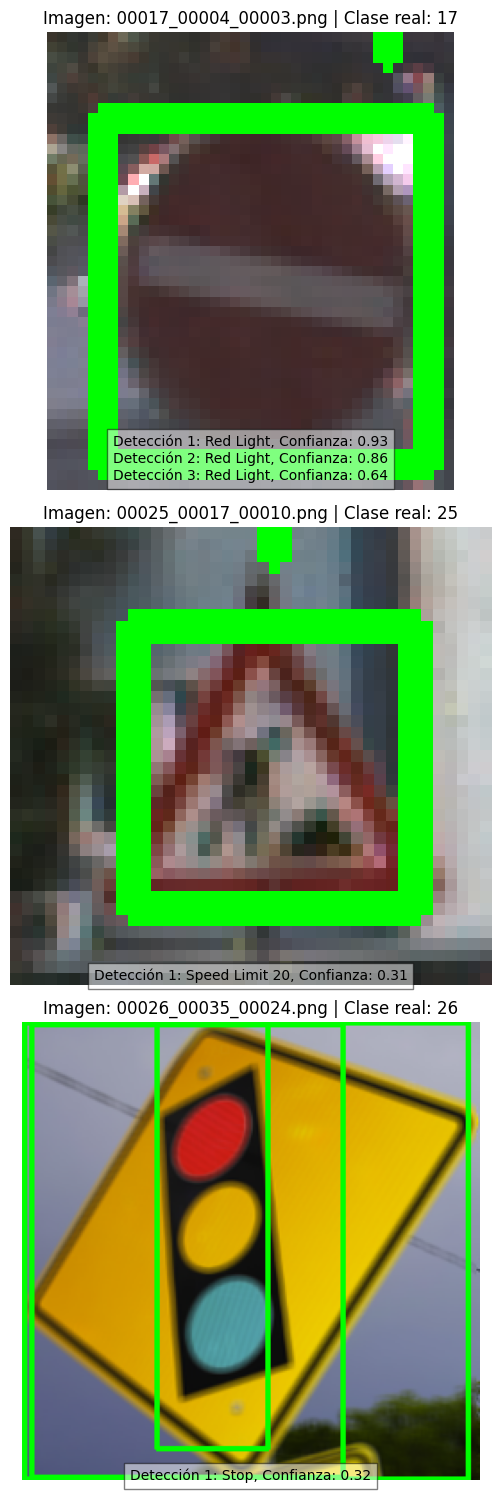

In [15]:
# Cargar el modelo YOLO
model = YOLO('traffic_sign_detector.pt')

# Procesar las imágenes del diccionario
df_resultados = procesar_diccionario_imagenes(muestra_imagenes, model, conf_threshold=0.25)

# Mostrar el DataFrame con los resultados
print("Resultados de la detección:")
display(df_resultados)

# Estadísticas básicas
print("\nEstadísticas:")
print(f"Total de imágenes procesadas: {df_resultados['ruta_imagen'].nunique()}")
print(f"Total de detecciones: {len(df_resultados[df_resultados['clase_predicha'].notna()])}")

# Mostrar distribución de clases predichas
if 'clase_predicha' in df_resultados.columns and df_resultados['clase_predicha'].notna().any():
    print("\nDistribución de clases predichas:")
    display(df_resultados['clase_predicha'].value_counts().head(10))

# Visualizar algunos resultados
visualizar_resultados_muestra(df_resultados, num_muestras=3)